In [87]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
context_length = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
number_embeddings = 384
n_heads = 6    # 384/6 - every head is 64 dim
n_layer = 6

dropout = 0.2
# ------------

torch.manual_seed(1337)

In [88]:
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('shake.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [89]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [90]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [91]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [93]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(number_embeddings, head_size, bias=False)
        self.query = nn.Linear(number_embeddings, head_size, bias=False)
        self.value = nn.Linear(number_embeddings, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length))) # this is called a buffer, it's not a parameter, and if you have to call it, you have to assign it to the module using a register buffer

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)

        # compute attention scores ("affinities")
        # we use scaled attention here
        weights = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T) 

        # ensure it doesn't communicate with the past - decoder attention
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)

        weights = F.softmax(weights, dim=-1) # (B, T, T)

        weights = self.dropout(weights)   # randomly prevent some of the nodes from communicating
        
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)

        # the output
        out = weights @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        
        return out

In [94]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(number_embeddings, number_embeddings)  # we add this projection, this is just a linear transformation 
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # concat on the C dim
        out = self.dropout(self.proj(out)) # projection, this is just a linear transformation on the outcome of the concatenation layer from above this line
        return out

In [95]:
class FeedFoward(nn.Module):
    """ a single linear layer followed by a non-linearity """

    def __init__(self, num_embd):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_embd, 4 * num_embd),
            nn.ReLU(),
            nn.Linear(4 * num_embd, num_embd), # this is the projection layer
            nn.Dropout(dropout)  # Dropout is something that you can add right before the residual connection back or right before the connection back into the original pathway
        )
        # we can have the projection layer here but it was placed above this line in the sequential container

    def forward(self, x):
        return self.net(x)

In [96]:
# here we added some changes for layernorm

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, num_embd, num_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        head_size = num_embd // num_head # this will become size 8

        # Communication
        self.sa = MultiHeadAttention(num_head, head_size) 

        # Computation
        self.ffwd = FeedFoward(num_embd)

        # layernorm
        self.ln1 = nn.LayerNorm(num_embd)
        self.ln2 = nn.LayerNorm(num_embd)


    def forward(self, x): 
        x = x + self.sa(self.ln1(x))     # we apply layer norm before going into the self attention
        x = x + self.ffwd(self.ln2(x))       # we apply layer norm before going into the feed forward
        return x

In [99]:
# simple implementation to plug the self attention into our model

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, number_embeddings)
        self.position_embedding_table = nn.Embedding(context_length, number_embeddings)
        self.blocks = nn.Sequential(*[Block(number_embeddings, num_head=4) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(number_embeddings)
        self.lm_head = nn.Linear(number_embeddings, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        token_embeddings = self.token_embedding_table(idx) # (B,T,C)
        position_embeddings = self.position_embedding_table(torch.arange(T, device=device))  # (T, C) from 0 to t-1

        x = token_embeddings + position_embeddings # (B,T,C)

        # apply heads of attention
        x = self.blocks(x)  

        # we went way too fast on calculating the logits before, so now we put before this the feed forward
        logits = self.lm_head(x) # (B,T, vocab_size)


        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the lastcontext_length tokens
            idx_cond = idx[:, -context_length:]

            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [100]:
model = BigramLanguageModel()
m = model.to(device)

In [101]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [102]:
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

10.788929 M parameters


step 0: train loss 3.9664, val loss 4.0026
step 10: train loss 2.9530, val loss 2.9735
step 20: train loss 2.7398, val loss 2.7649
step 30: train loss 2.6325, val loss 2.6507
step 40: train loss 2.5795, val loss 2.6017
step 50: train loss 2.5447, val loss 2.5721
step 60: train loss 2.5249, val loss 2.5504
step 70: train loss 2.5102, val loss 2.5348
step 80: train loss 2.5021, val loss 2.5191
step 90: train loss 2.4910, val loss 2.5120


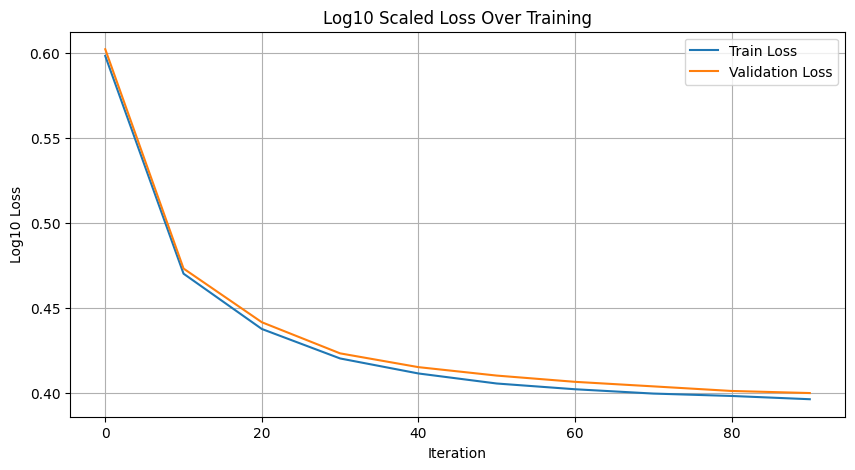

In [103]:
import matplotlib.pyplot as plt
import torch

# Initialize lists to store the loss values
train_losses = []
val_losses = []

# Define the number of iterations and the evaluation interval
num_iterations = 100
eval_interval = 10  # Adjust this to your desired evaluation frequency

for iter in range(num_iterations):
    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # Store the loss values
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

# Convert the lists of losses to PyTorch tensors
train_losses_tensor = torch.tensor(train_losses)
val_losses_tensor = torch.tensor(val_losses)

# Compute the log10 of the loss values
log_train_losses = torch.log10(train_losses_tensor)
log_val_losses = torch.log10(val_losses_tensor)

# Now plot the log-scaled loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, num_iterations, eval_interval), log_train_losses.numpy(), label='Train Loss')  # Convert to NumPy array for plotting
plt.plot(range(0, num_iterations, eval_interval), log_val_losses.numpy(), label='Validation Loss')  # Convert to NumPy array for plotting
plt.xlabel('Iteration')
plt.ylabel('Log10 Loss')
plt.title('Log10 Scaled Loss Over Training')
plt.legend()
plt.grid(True)
plt.show()

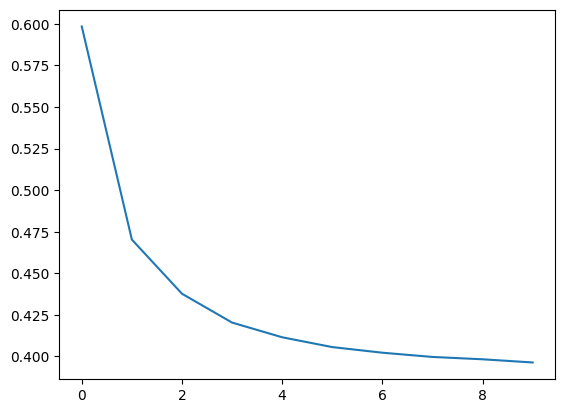

In [107]:
plt.plot(log_train_losses)

In [20]:
for iter in range(100):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    break

step 0: train loss 2.4859, val loss 2.5087


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

# function to get a batch of data for evaluation
def get_evaluation_batch():
    X, Y = get_batch('validation')  # assuming you have implemented get_batch for 'val' split
    return X

# function to plot activation distribution for transformer
def plot_activation_distribution(model):
    with torch.no_grad():
        model.eval()
        X = get_evaluation_batch()
        out, _ = model(X)  # assuming your model returns logits and loss
        for i, block in enumerate(model.blocks):
            if isinstance(block, MultiHeadAttention):
                plt.figure(figsize=(20, 4))
                legends = []
                for j, head in enumerate(block.heads):
                    t = head(X)
                    print('at block %d, head %d: mean %+.2f, std %.2f, saturated: %.2f%%' % (
                        i, j, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
                    hy, hx = torch.histogram(t, density=True)
                    plt.plot(hx[:-1].detach(), hy.detach())
                    legends.append(f'block {i}, head {j}')
                plt.legend(legends)
                plt.title('activation distribution - block %d' % i)
                plt.show()
        model.train()

# function to plot gradient distribution for transformer
def plot_gradient_distribution(model):
    with torch.no_grad():
        model.eval()
        X = get_evaluation_batch()
        _, loss = model(X)
        loss.backward()
        for i, block in enumerate(model.blocks):
            if isinstance(block, MultiHeadAttention):
                plt.figure(figsize=(20, 4))
                legends = []
                for j, head in enumerate(block.heads):
                    t = head(X).grad
                    print('at block %d, head %d: mean %+f, std %e' % (i, j, t.mean(), t.std()))
                    hy, hx = torch.histogram(t, density=True)
                    plt.plot(hx[:-1].detach(), hy.detach())
                    legends.append(f'block {i}, head {j}')
                plt.legend(legends)
                plt.title('gradient distribution - block %d' % i)
                plt.show()
        model.train()

# function to plot gradient distribution for parameters in transformer
def plot_parameter_gradient_distribution(model):
    with torch.no_grad():
        model.eval()
        X = get_evaluation_batch()
        _, loss = model(X)
        loss.backward()
        plt.figure(figsize=(20, 4))
        legends = []
        for i, param in enumerate(model.parameters()):
            if param.requires_grad and param.ndim == 2:
                t = param.grad
                print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (
                    tuple(param.shape), t.mean(), t.std(), t.std() / param.std()))
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'parameter {i}, {tuple(param.shape)}')
        plt.legend(legends)
        plt.title('parameter gradient distribution')
        plt.show()

# function to plot update to data ratio for parameters in transformer
def plot_update_to_data_ratio(model, update_to_data_ratio):
    plt.figure(figsize=(20, 4))
    legends = []
    for i, _ in enumerate(model.parameters()):
        if i < len(update_to_data_ratio[0]) and i % 2 == 0:  # considering update ratio for every alternate parameter
            plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
            legends.append('param %d' % i)
    plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k')  # indicate desired update ratio
    plt.title('update to data ratio')
    plt.legend(legends)
    plt.show()





In [62]:
X, _ = get_batch('val')
X

torch.Size([64, 256])

In [63]:
out, _ = model(X)
out

tensor([[[ 3.4194e+00,  5.8076e+00,  1.0911e+00,  ..., -2.1556e-01,
           2.1234e+00, -1.1568e+00],
         [-1.8366e+00, -1.7497e+00, -3.6225e+00,  ..., -2.4648e+00,
           2.6041e+00, -1.8597e+00],
         [ 1.0686e+00,  2.7166e+00, -7.3961e-01,  ..., -7.7444e-01,
           7.6470e-01, -1.9132e+00],
         ...,
         [ 2.9132e-01,  2.0810e+00, -9.0999e-01,  ..., -3.4938e+00,
           4.6142e-01, -2.6937e+00],
         [ 2.1335e+00,  4.9496e+00, -6.5519e-01,  ..., -2.4621e+00,
           4.0263e+00, -2.8865e+00],
         [ 2.7994e+00,  6.5442e+00,  2.2630e+00,  ..., -2.2830e+00,
          -7.2099e-01, -1.7383e+00]],

        [[-3.8716e+00, -2.8788e+00, -4.7321e+00,  ..., -4.2474e+00,
           2.9308e+00, -2.6291e+00],
         [ 6.6647e-01,  4.1728e+00, -1.0635e+00,  ..., -3.0045e+00,
           2.1208e+00, -3.8992e+00],
         [ 1.7415e-03,  3.2647e+00, -1.3196e+00,  ..., -1.2860e+00,
           3.6561e+00, -1.4794e+00],
         ...,
         [ 4.6115e+00,  5

In [33]:
for i, block in enumerate(model.blocks):
    print(f"index: {i}, block: {block}")

index: 0, block: Block(
  (sa): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (key): Linear(in_features=384, out_features=96, bias=False)
        (query): Linear(in_features=384, out_features=96, bias=False)
        (value): Linear(in_features=384, out_features=96, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (proj): Linear(in_features=384, out_features=384, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (ffwd): FeedFoward(
    (net): Sequential(
      (0): Linear(in_features=384, out_features=1536, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1536, out_features=384, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)
index: 1, block: Block(
  (sa): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (key): Linear(in_features=384, out_

In [76]:
model

BigramLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=384, out_features=96, bias=False)
            (query): Linear(in_features=384, out_features=96, bias=False)
            (value): Linear(in_features=384, out_features=96, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affi

In [78]:
for name, layer in model.named_modules():
    print(name, layer)

 BigramLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=384, out_features=96, bias=False)
            (query): Linear(in_features=384, out_features=96, bias=False)
            (value): Linear(in_features=384, out_features=96, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_aff

In [79]:
def layer_statistics(model):
    stats = {}
    for name, layer in model.named_modules():
        # Check if the layer has weights (e.g., Linear, Conv layers)
        if hasattr(layer, 'weight') and hasattr(layer.weight, 'data'):
            stats[name] = {
                'weight_mean': layer.weight.data.mean().item(),
                'weight_std': layer.weight.data.std().item(),
                'weight_max': layer.weight.data.max().item(),
                'weight_min': layer.weight.data.min().item(),
                'weight_norm': layer.weight.data.norm().item(),
            }
            # Check if the layer has biases
            if hasattr(layer, 'bias') and layer.bias is not None:
                stats[name].update({
                    'bias_mean': layer.bias.data.mean().item(),
                    'bias_std': layer.bias.data.std().item(),
                    'bias_max': layer.bias.data.max().item(),
                    'bias_min': layer.bias.data.min().item(),
                    'bias_norm': layer.bias.data.norm().item(),
                })
    return stats

# Assuming 'model' is your BigramLanguageModel instance
stats = layer_statistics(model)

# Print out the statistics
for layer_name, layer_stats in stats.items():
    print(f"Layer: {layer_name}")
    for stat_name, stat_value in layer_stats.items():
        print(f"  {stat_name}: {stat_value}")
    print()

Layer: token_embedding_table
  weight_mean: 0.003120766021311283
  weight_std: 0.9999886155128479
  weight_max: 3.8206722736358643
  weight_min: -4.246124744415283
  weight_norm: 157.983154296875

Layer: position_embedding_table
  weight_mean: 0.0004400835314299911
  weight_std: 0.9949462413787842
  weight_max: 4.812939167022705
  weight_min: -3.9327151775360107
  weight_norm: 311.9485778808594

Layer: blocks.0.sa.heads.0.key
  weight_mean: 3.029516665264964e-05
  weight_std: 0.029840251430869102
  weight_max: 0.064152292907238
  weight_min: -0.06318517029285431
  weight_norm: 5.729254245758057

Layer: blocks.0.sa.heads.0.query
  weight_mean: -0.00016252027126029134
  weight_std: 0.029893632978200912
  weight_max: 0.06539029628038406
  weight_min: -0.06603138148784637
  weight_norm: 5.739584445953369

Layer: blocks.0.sa.heads.0.value
  weight_mean: 7.175927021307871e-05
  weight_std: 0.029530446976423264
  weight_max: 0.06426113098859787
  weight_min: -0.06215154379606247
  weight_norm

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming 'model' is your BigramLanguageModel instance
# and 'input_data' is a tensor representing your input

# Step 2: Define a hook to capture the activations
activations = []
def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

# Register the hook to the ReLU activations in the feedforward blocks
for name, block in model.blocks.named_children():
    block.ffwd.net[1].register_forward_hook(get_activation(name))

# Step 3: Run the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    _ = model(input_data)

# Step 4: Plot the activations
# You might have multiple sets of activations, one for each block
# Here we plot the activations for the first block as an example
plt.figure(figsize=(20, 10))
# Assuming the activations are stored in a list and we're interested in the first one
# You may need to adjust the index based on which layer's activations you want to plot
plt.imshow(activations[0].abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

# Remove hooks (important to prevent memory leaks)
for handle in handles:
    handle.remove()

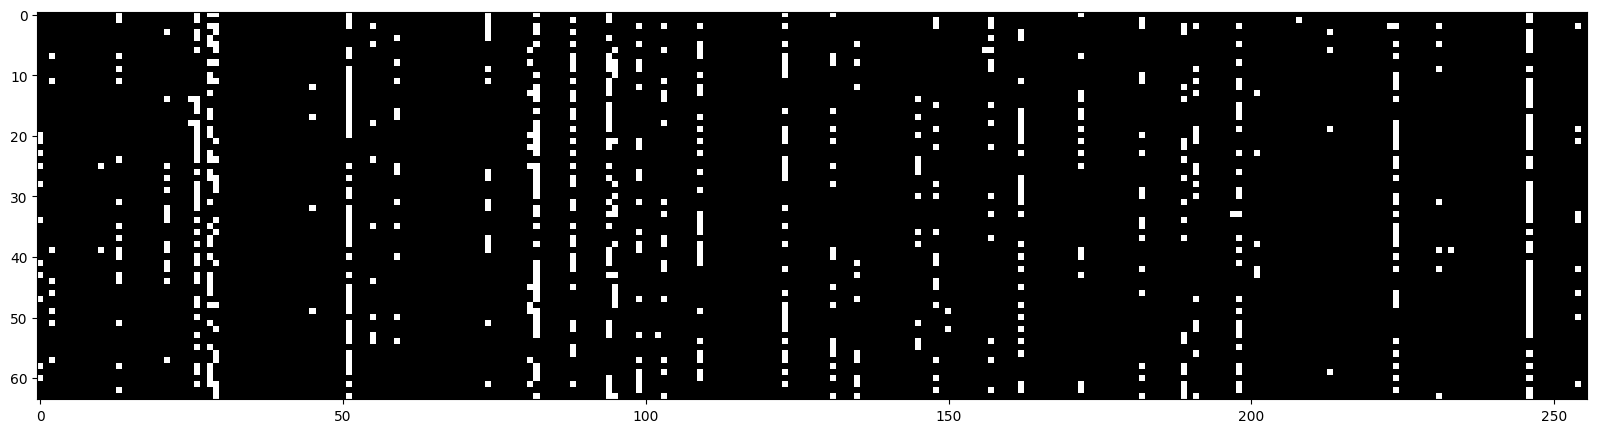

In [82]:
import torch
import matplotlib.pyplot as plt

# Assuming the rest of your model and functions are defined as before

# Register the hook to the ReLU activations in the feedforward blocks
activations = []
def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

# Choose a specific block and ReLU layer to attach the hook
# Adjust the index based on which block's activations you want to plot
model.blocks[0].ffwd.net[1].register_forward_hook(get_activation('block0_relu'))

# Get a batch of validation data
X, _ = get_batch('val')

# Run the model to capture the activations
model.eval()
with torch.no_grad():
    _ = model(X)

# # Plot the activations
# plt.figure(figsize=(20, 10))
# # Assuming the activations are stored in a list and we're interested in the first one
# plt.imshow(activations[0].abs().cpu() > 0.99, cmap='gray', interpolation='nearest')
# plt.show()

# Select the first sequence in the batch and the first feature across all positions
activations_2d = activations[0][:, :, 0].cpu()

# Now plot the activations for this single feature
plt.figure(figsize=(20, 10))
plt.imshow(activations_2d.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

# Remove the hook after use to prevent memory leaks
model.blocks[0].ffwd.net[1]._forward_hooks.clear()

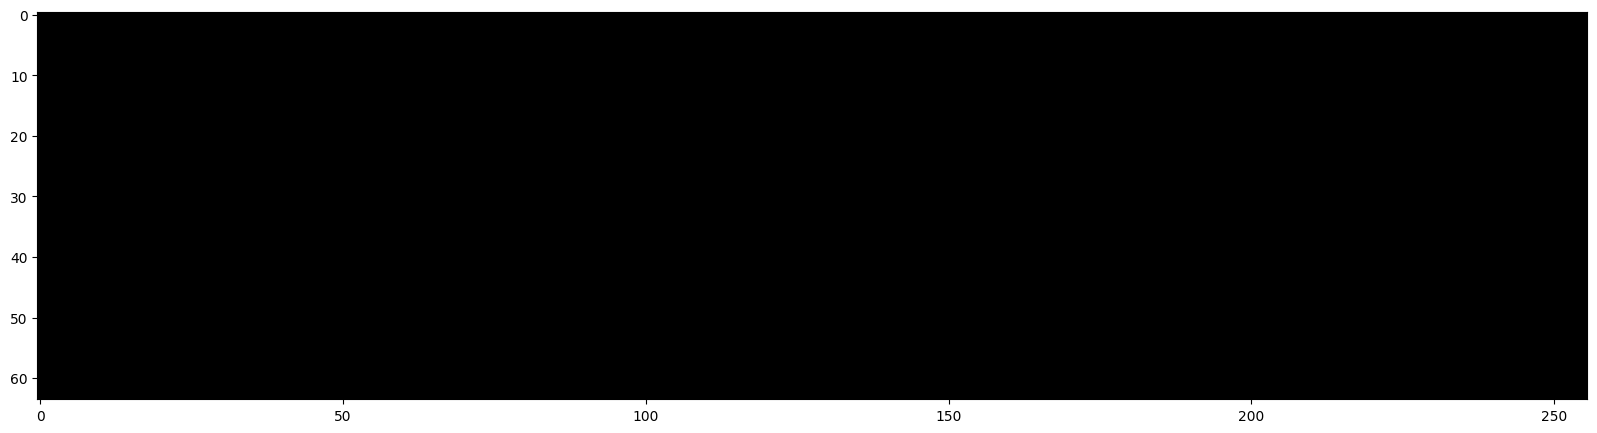

In [86]:
import torch
import matplotlib.pyplot as plt

# Assuming the rest of your model and functions are defined as before

# Register the hook to the ReLU activations in the feedforward blocks
activations = []
def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

# Choose a specific block and ReLU layer to attach the hook
# Adjust the index based on which block's activations you want to plot
model.blocks[0].ffwd.net[1].register_forward_hook(get_activation('block0_relu'))

# Get a batch of validation data
X, _ = get_batch('val')

# Run the model to capture the activations
model.eval()
with torch.no_grad():
    _ = model(X)

# Average over the feature dimension
activations_2d = activations[0].mean(dim=2).cpu()

# Now plot the averaged activations
plt.figure(figsize=(20, 10))
plt.imshow(activations_2d.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

# Remove the hook after use to prevent memory leaks
model.blocks[0].ffwd.net[1]._forward_hooks.clear()

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=5000)[0].tolist()))



Thirdings:
Why torneys o'er the queen and ill consent,
The heavens lies sell, and benefit doth die;
There to kill'd the haired and the awhile.
Fear you unwillingness in raged to anoventeen.

DUKE OF YORK:
Strike it like life was the sea:
Why, he hath that, were's at all the flocket.

GLOUCESTER:
Be coverfully the accopplaint.

QUEEN MARGARET:
Hark, you reprote in the east; and, as yourself
Your husband myself constance; to see the day it be depositife:
Blaw the people condurAge now,
And would: I have tell my dead with statings;
Like so my no fair day I play them by spegght,
I rave past ill to it tear these arise.
First, if thou dwell not be a cold tale:
Hie were it in at liar
Too frozen renownest quade or staip'd moars;
Verenting a master territy I should nave,
Plebers more lie eneninger truth.
Thus combs the wrong, before such and over you
Leong bey enow'd the deputy bark of policion.

RIVERS:
Dates, my lord;
Or six fains begging them like a mazzre and
And urge I give by words, lose

In [ ]:
# Define the file path where you want to save the model state
checkpoint_path = 'model_checkpoint.pth'

# Create a dictionary to save all necessary information
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'batch_size': batch_size,
        'block_size': context_length,
        'max_iters': max_iters,
        'eval_interval': eval_interval,
        'learning_rate': learning_rate,
        'device': device,
        'eval_iters': eval_iters,
        'n_embd': number_embeddings,
        'n_heads': n_heads,
        'n_layer': n_layer,
        'dropout': dropout,
        'vocab_size': vocab_size
    },
    'additional_info': {
        # Add any other information you want to save, such as training history, current iteration, etc.
    }
}

# Save the checkpoint
torch.save(checkpoint, checkpoint_path)

In [ ]:
# Define the file path where you want to save the model state
checkpoint_path = 'backup/model_checkpoint.pth'
# Load the saved checkpoint
checkpoint = torch.load(checkpoint_path)

# Restore the model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Ensure the model and optimizer are in the correct mode (training or evaluation)
model.train()  # or model.eval() depending on the mode you saved


BigramLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=384, out_features=96, bias=False)
            (query): Linear(in_features=384, out_features=96, bias=False)
            (value): Linear(in_features=384, out_features=96, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affi

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
context


tensor([[0]], device='cuda:0')

In [ ]:
decode([0])

'\n'

In [ ]:
encode("Hello")

[20, 43, 50, 50, 53]

In [ ]:
prompt = torch.tensor(encode("Hello"), dtype=torch.long, device=device)
print(prompt.size())
print(prompt.stride())
prompt

torch.Size([5])
(1,)


tensor([20, 43, 50, 50, 53], device='cuda:0')

In [ ]:
prompt = prompt.unsqueeze(0)
print(prompt.size())
print(prompt.stride())
prompt

torch.Size([1, 5])
(5, 1)


tensor([[20, 43, 50, 50, 53]], device='cuda:0')

In [ ]:
model.eval()

BigramLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=384, out_features=96, bias=False)
            (query): Linear(in_features=384, out_features=96, bias=False)
            (value): Linear(in_features=384, out_features=96, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affi

In [ ]:
print(decode(m.generate(prompt, max_new_tokens=100)[0].tolist()))

Hellows birds to see his hate with disposition.

RICHMOND:
I am long in this morning.
Who doth the write 


In [ ]:
prompt = torch.tensor(encode("KING CHARLES III"), dtype=torch.long, device=device)
prompt = prompt.unsqueeze(0)
print(prompt.size())
print(prompt.stride())
prompt

torch.Size([1, 16])
(16, 1)


tensor([[23, 21, 26, 19,  1, 15, 20, 13, 30, 24, 17, 31,  1, 21, 21, 21]],
       device='cuda:0')

In [ ]:
print(decode(m.generate(prompt, max_new_tokens=200)[0].tolist()))

KING CHARLES III:
How the prison?

QUEEN MARGARET:
Call thee unto me, my Lord of Warwick of Welcome.

QUEEN:
Why, are you not so? what stay?

KING RICHARD III:
Be thy inward of thee?

Second Keeper:
Here's no so.
Ah,
